# Part 4 : Sentiment analysis using LSTM

## Read, Main statistics

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Unzip the dataset and read csv file
zip_file = 'archive.zip'
extract_folder = 'twitter_dataset'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

folder_path = 'twitter_dataset/'
csv_file = 'Tweets.csv'
csv_path = folder_path + csv_file
tweets_df = pd.read_csv(csv_path)

In [4]:
tweets_df.shape

(14640, 15)

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Visualization

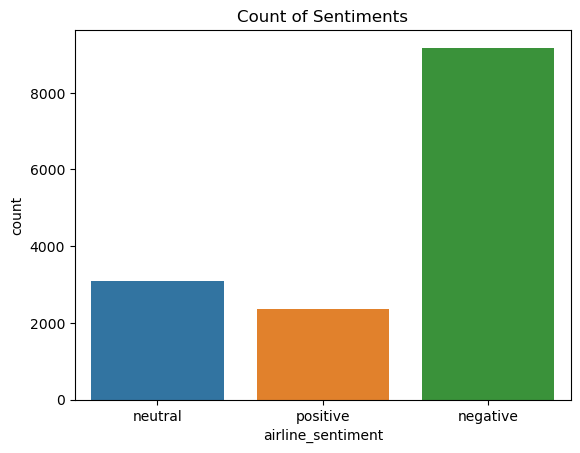

In [6]:
# Visualization 1: Count of sentiments

sns.countplot(x='airline_sentiment', data=tweets_df)
plt.title('Count of Sentiments')
plt.show()

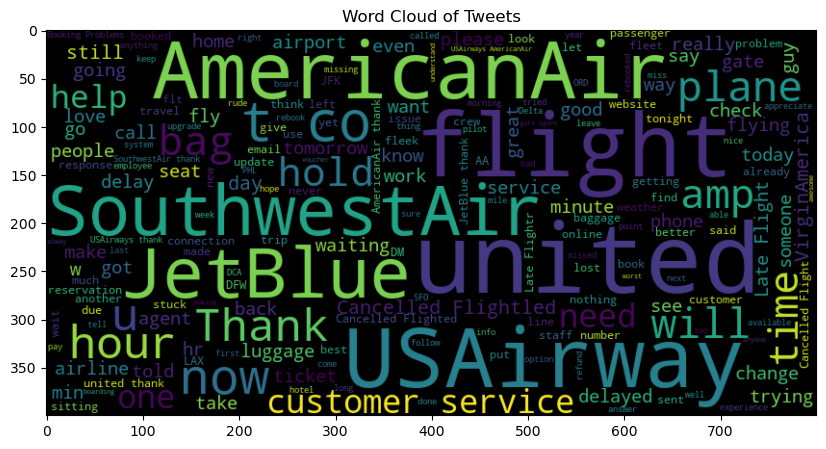

In [7]:
# Visualization 2: Word cloud of tweets

all_text = ' '.join(tweets_df['text'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.title('Word Cloud of Tweets')
plt.show()

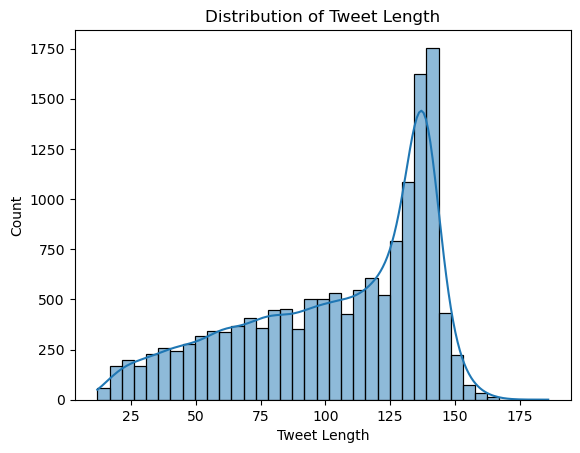

In [8]:
# Visualization 3: Length distribution of tweets

tweets_df['text_length'] = tweets_df['text'].apply(len)
sns.histplot(data=tweets_df, x='text_length', kde=True)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.show()

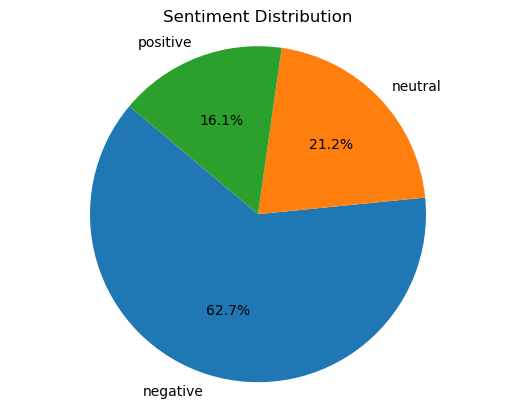

In [9]:
# Visualization 4: Pie chart of sentiment distribution

sentiment_counts = tweets_df['airline_sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

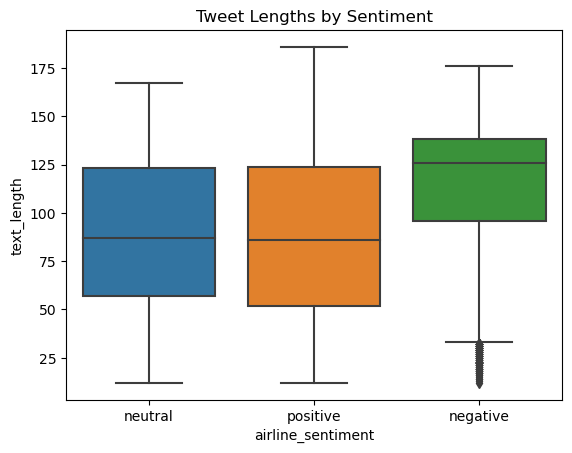

In [10]:
# Visualization 5: Box plot of tweet lengths by sentiment

sns.boxplot(x='airline_sentiment', y='text_length', data=tweets_df)
plt.title('Tweet Lengths by Sentiment')
plt.show()

## Preprocessing

In [11]:
# Preprocessing functions

def convert_to_lowercase(text):
    return text.lower()
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
def remove_stopwords(text):
    stopwords_set = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_set]
    return ' '.join(filtered_words)
def stemming(text):
    ps = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)
def clean_text(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    text = " ".join(word.strip() for word in re.split('#|_', text))
    text = re.sub("\s\s+" , " ", text)
    return text

def preprocess_text(text):
    text = convert_to_lowercase(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = lemmatization(text)
    text = clean_text(text)
    return text

In [12]:
# Applying text preprocessing
tweets_df['cleaned_text_df'] = tweets_df['text'].apply(preprocess_text)

tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive':2})
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_length,cleaned_text_df
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),35,virginamerica dhepburn said
1,570301130888122368,2,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72,virginamerica plu ad commerci experi tacki
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),71,virginamerica today must mean need take anoth ...
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126,virginamerica realli aggress blast obnoxi ente...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55,virginamerica realli big bad thing


In [13]:
# Encoding labels
label_encoder = LabelEncoder()
tweets_df['airline_sentiment'] = label_encoder.fit_transform(tweets_df['airline_sentiment'])

# Tokenizing and padding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_df['cleaned_text_df'])
sequences = tokenizer.texts_to_sequences(tweets_df['cleaned_text_df'])
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
tweets_df.head

<bound method NDFrame.head of                  tweet_id  airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513                  1                        1.0000   
1      570301130888122368                  2                        0.3486   
2      570301083672813571                  1                        0.6837   
3      570301031407624196                  0                        1.0000   
4      570300817074462722                  0                        1.0000   
...                   ...                ...                           ...   
14635  569587686496825344                  2                        0.3487   
14636  569587371693355008                  0                        1.0000   
14637  569587242672398336                  1                        1.0000   
14638  569587188687634433                  0                        1.0000   
14639  569587140490866689                  1                        0.6771   

               negativereason  ne

In [14]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, tweets_df['airline_sentiment'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the sizes
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Validation set size:", X_val.shape[0])

Train set size: 11712
Test set size: 1464
Validation set size: 1464


In [15]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

## LSTM Base Model

In [16]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output1, _ = self.lstm1(embedded)
        output2, _ = self.lstm2(output1)
        output3, (hidden, _) = self.lstm3(output2)
        output = self.fc(hidden[-1])
        return output

In [17]:
# Initializing model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = 3
num_layers = 3
dropout = 0.2
batch_size = 64
epochs = 25

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [18]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Training the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = correct_train / total_train

    # Validation model
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = correct_val / total_val
    
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

Epoch 1/25, Training Loss: 0.8623, Training Accuracy: 62.44%, Validation Loss: 0.7333, Validation Accuracy: 67.49%
Epoch 2/25, Training Loss: 0.7191, Training Accuracy: 69.62%, Validation Loss: 0.6512, Validation Accuracy: 73.36%
Epoch 3/25, Training Loss: 0.6453, Training Accuracy: 74.43%, Validation Loss: 0.6314, Validation Accuracy: 75.55%
Epoch 4/25, Training Loss: 0.5875, Training Accuracy: 76.42%, Validation Loss: 0.6256, Validation Accuracy: 74.04%
Epoch 5/25, Training Loss: 0.5238, Training Accuracy: 79.76%, Validation Loss: 0.6153, Validation Accuracy: 76.57%
Epoch 6/25, Training Loss: 0.4858, Training Accuracy: 82.14%, Validation Loss: 0.6531, Validation Accuracy: 76.43%
Epoch 7/25, Training Loss: 0.4326, Training Accuracy: 84.84%, Validation Loss: 0.6998, Validation Accuracy: 76.16%
Epoch 8/25, Training Loss: 0.3811, Training Accuracy: 87.15%, Validation Loss: 0.6371, Validation Accuracy: 75.41%
Epoch 9/25, Training Loss: 0.3364, Training Accuracy: 89.32%, Validation Loss: 0

In [20]:
# Save 
torch.save(model.state_dict(), 'lstm_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [21]:
# Testing
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_accuracy = correct_test / total_test

print(f'Testing Loss: {test_loss / len(test_loader):.4f}')
print(f'Testing Accuracy: {100 * test_accuracy:.2f}%')

Testing Loss: 0.9779
Testing Accuracy: 74.32%


In [22]:
# Evaluate 
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

In [23]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(y_true, y_pred, target_names=['Neutral', 'Positive', 'Negative'])
print("Classification Report:")
print(report)

Confusion Matrix:
[[784 113  33]
 [114 142  31]
 [ 39  46 162]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.84      0.84      0.84       930
    Positive       0.47      0.49      0.48       287
    Negative       0.72      0.66      0.68       247

    accuracy                           0.74      1464
   macro avg       0.68      0.66      0.67      1464
weighted avg       0.74      0.74      0.74      1464



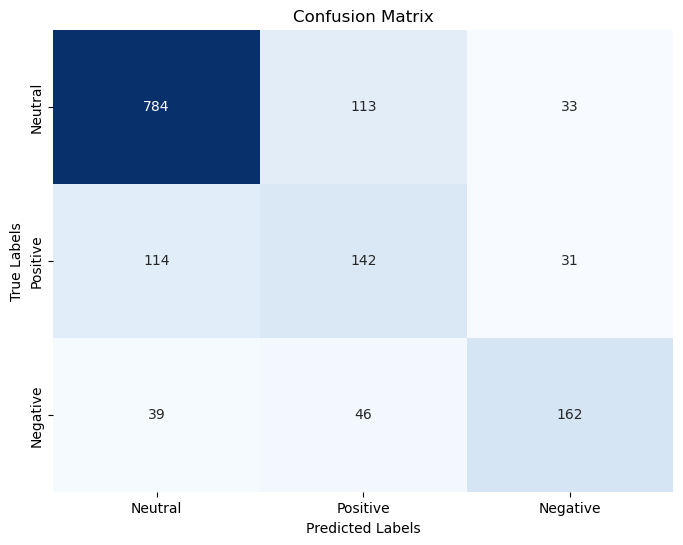

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Neutral', 'Positive', 'Negative'], 
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
# Printing validation, training accuracy, and testing loss and accuracy
print("LSTM")
print(f'Final Training Loss: {avg_train_loss:.4f}')
print(f'Final Training Accuracy: {100 * train_accuracy:.2f}%')

print(f'Final Validation Loss: {avg_val_loss:.4f}')
print(f'Final Validation Accuracy: {100 * val_accuracy:.2f}%')

print(f'Final Testing Loss: {test_loss / len(test_loader):.4f}')
print(f'Final Testing Accuracy: {100 * test_accuracy:.2f}%')

LSTM
Final Training Loss: 0.1303
Final Training Accuracy: 96.93%
Final Validation Loss: 0.9604
Final Validation Accuracy: 75.55%
Final Testing Loss: 0.9779
Final Testing Accuracy: 74.32%


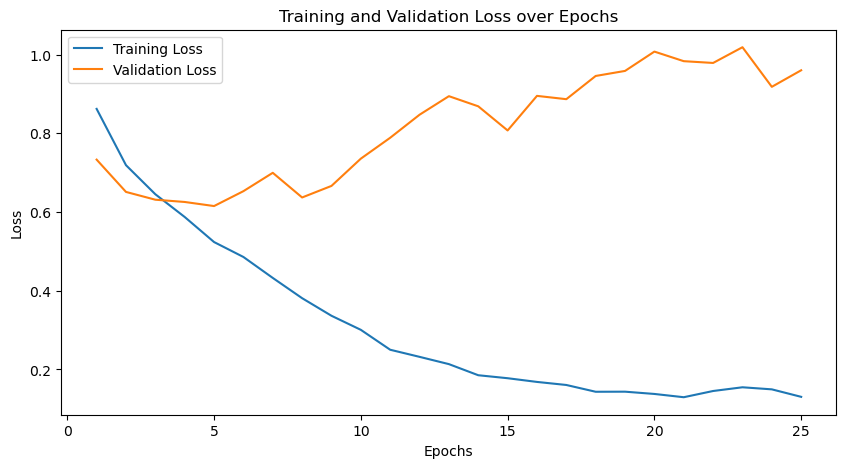

In [26]:
# Plotting the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

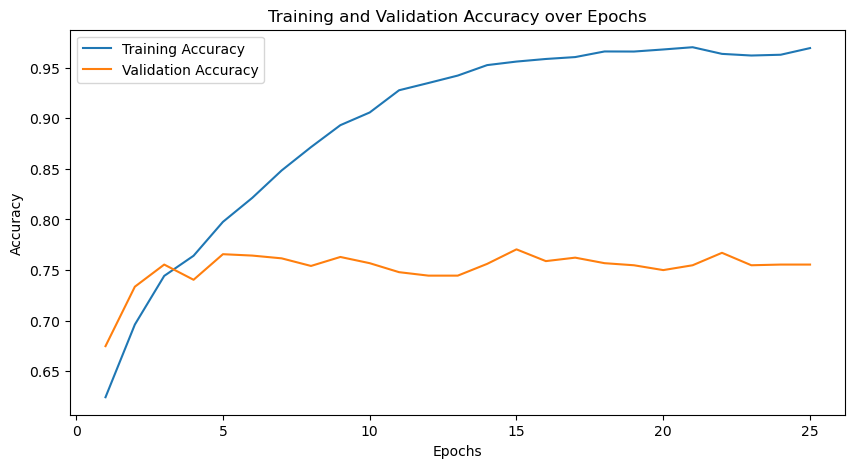

In [27]:
# Plotting the training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

## Improvised LSTM (Bidirectional)

In [28]:
import torch
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.bilstm3 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output1, _ = self.bilstm1(embedded)
        output2, _ = self.bilstm2(output1)
        output3, (hidden, _) = self.bilstm3(output2)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(hidden)
        return output

In [29]:
# Initializing model parameters

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = 3
num_layers = 3
dropout = 0.2
batch_size = 64
epochs = 25

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [30]:
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Lists to store loss and accuracy values for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training the model
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    train_accuracy = correct_train / total_train
    
    # Validation 
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
        val_accuracy = correct_val / total_val

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

Epoch 1/25, Training Loss: 0.8123, Training Accuracy: 65.04%, Validation Loss: 0.6445, Validation Accuracy: 73.09%
Epoch 2/25, Training Loss: 0.6621, Training Accuracy: 73.18%, Validation Loss: 0.6220, Validation Accuracy: 74.66%
Epoch 3/25, Training Loss: 0.5663, Training Accuracy: 77.83%, Validation Loss: 0.5812, Validation Accuracy: 76.30%
Epoch 4/25, Training Loss: 0.4968, Training Accuracy: 80.86%, Validation Loss: 0.6185, Validation Accuracy: 76.30%
Epoch 5/25, Training Loss: 0.4134, Training Accuracy: 85.14%, Validation Loss: 0.5965, Validation Accuracy: 76.02%
Epoch 6/25, Training Loss: 0.3559, Training Accuracy: 87.21%, Validation Loss: 0.6309, Validation Accuracy: 77.39%
Epoch 7/25, Training Loss: 0.2797, Training Accuracy: 90.52%, Validation Loss: 0.6880, Validation Accuracy: 75.75%
Epoch 8/25, Training Loss: 0.2277, Training Accuracy: 92.75%, Validation Loss: 0.7701, Validation Accuracy: 77.73%
Epoch 9/25, Training Loss: 0.1902, Training Accuracy: 94.15%, Validation Loss: 0

In [32]:
# Testing the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_accuracy = correct_test / total_test

print(f'Testing Loss: {test_loss / len(test_loader):.4f}')
print(f'Testing Accuracy: {100 * test_accuracy:.2f}%')

Testing Loss: 1.2122
Testing Accuracy: 75.82%


In [33]:
# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

report = classification_report(y_true, y_pred, target_names=['Neutral', 'Positive', 'Negative'])
print("Classification Report:")
print(report)

Confusion Matrix:
[[784 113  33]
 [114 142  31]
 [ 39  46 162]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.84      0.84      0.84       930
    Positive       0.47      0.49      0.48       287
    Negative       0.72      0.66      0.68       247

    accuracy                           0.74      1464
   macro avg       0.68      0.66      0.67      1464
weighted avg       0.74      0.74      0.74      1464



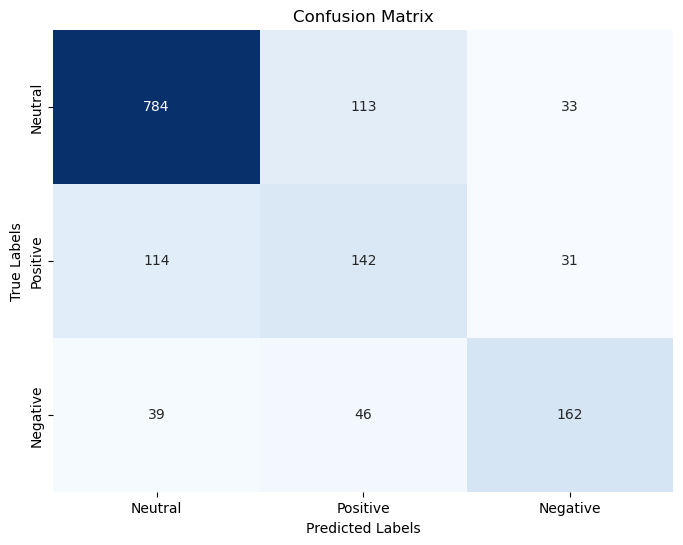

In [34]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Neutral', 'Positive', 'Negative'], 
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Save the model weights
torch.save(model.state_dict(), 'best_bilstm_model.pth')

In [35]:
# Printing validation, training accuracy, and testing loss and accuracy
print("IMPROVED LSTM")
print(f'Final Training Loss: {avg_train_loss:.4f}')
print(f'Final Training Accuracy: {100 * train_accuracy:.2f}%')

print(f'Final Validation Loss: {avg_val_loss:.4f}')
print(f'Final Validation Accuracy: {100 * val_accuracy:.2f}%')

print(f'Final Testing Loss: {test_loss / len(test_loader):.4f}')
print(f'Final Testing Accuracy: {100 * test_accuracy:.2f}%')

IMPROVED LSTM
Final Training Loss: 0.0492
Final Training Accuracy: 98.58%
Final Validation Loss: 1.2201
Final Validation Accuracy: 75.61%
Final Testing Loss: 1.2122
Final Testing Accuracy: 75.82%


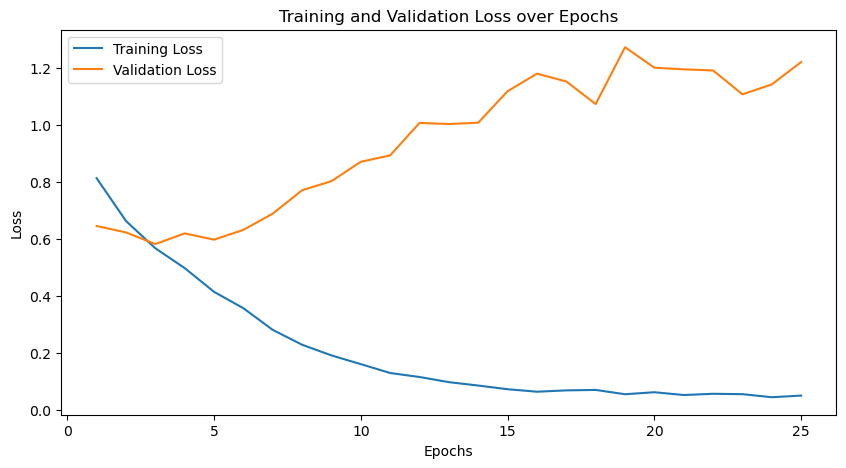

In [36]:
# Plotting the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

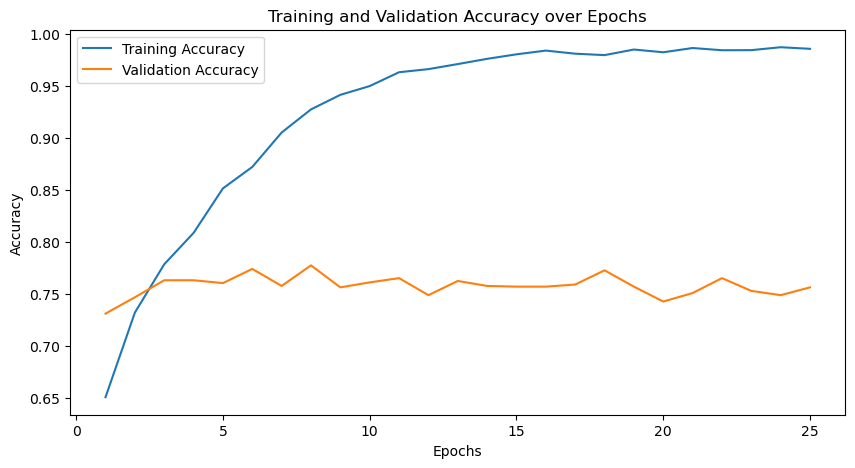

In [37]:
# Plotting the training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()